In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from IPython.display import Markdown
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from scipy.spatial.distance import cdist
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.pipeline import (
    Pipeline,
    TransformerMixin
)

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder
)

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    StratifiedKFold
)


In [2]:
data_path = Path('../data/raw/data.xls')
dict_path = Path('../data/external/dicionario.csv')

In [3]:
df = (
    pd
    .read_excel(data_path, header=1)
    .rename(columns={
        'default payment next month': 'DEFAULT_PAY'
    })
)
display(Markdown('### Conjunto de dados'))
display(df.head())


df_dict = (
    pd
    .read_csv(dict_path)
    .replace({
        'default payment next month': 'DEFAULT_PAY'
    })
)
display(Markdown('### Dicionário de dados'))
display(df_dict.head())

### Conjunto de dados

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_PAY
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Dicionário de dados

,variavel,significado,tipo
0,ID,Identificador unico,continuo
1,LIMIT_BAL,Valor do crédito concedido (Novo Dolár Taiwanês ),continuo
2,SEX,Genero (1= masculino; 2= feminino),nominal
3,EDUCATION,Educação Nivel de Escolaridade (1 = pós-gradua...,nominal
4,MARRIAGE,Estado civil (1 = casado; 2 = solteiro; 3 = ou...,nominal


In [4]:
target_column = 'DEFAULT_PAY'
useless_columns = ['ID', target_column]
continuous_columns = (
    df_dict
    .query('tipo == "continuo" and variavel not in @useless_columns')
    .variavel
    .to_list()
)
nominal_columns = (
    df_dict
    .query('tipo == "nominal" and variavel not in @useless_columns')
    .variavel
    .to_list()
)

In [5]:
class OutlierExtractor(TransformerMixin):
    def __init__(self, columns, threshold=3, **kwargs):
        self.threshold = threshold
        self.columns = columns
        self.kwargs = kwargs

    def transform(self, X, y=None):
        X_ = np.asarray(X[self.columns])
        outliers_zscore = np.abs(cdist(self.avg[np.newaxis], X_) / self.std)[0]
        if y is not None:
            y = np.asarray(y)
            return (
                X[outliers_zscore <= self.threshold],
                y[outliers_zscore <= self.threshold]
            )
        
        return X[outliers_zscore <= self.threshold]
    
    def fit(self, X, y=None):
        X = np.asarray(X[self.columns])
        self.std = X.std()
        self.avg = X.mean(axis=0)
        return self

In [6]:
continuous_preprocessor = Pipeline(steps=[
    # ('outlier_extractor', OutlierExtractor(columns = continuous_columns)), # Tratamento de dados discrepantes
    ('missing_data', SimpleImputer(strategy='mean')), # Tratamento de dados faltantes
    # Seleção de variáveis
    ('normalization', MinMaxScaler()) # Normalização
])

nominal_preprocessor = Pipeline(steps=[
    # Tratamento de dados discrepantes
    ('missing_data', SimpleImputer(strategy='most_frequent')), # Tratamento de dados faltantes
    ('encoder', OneHotEncoder(sparse=False)), # Codificação de variáveis
    # Seleção de variáveis
    #('normalization', MinMaxScaler())# Normalização 
])

preprocessor = ColumnTransformer(transformers=[
    ('continuous', continuous_preprocessor, continuous_columns),
    ('nominal', nominal_preprocessor, nominal_columns)
])

In [20]:
models = [
    ("logistic regression", LogisticRegression(max_iter=1000)),
    ("support vector machine ", SVC(max_iter=5000)),
    ("k nearest neighbors", KNeighborsClassifier()),
    ("decision tree", DecisionTreeClassifier()),
    ("random forest", RandomForestClassifier()),
    ("mlp", MLPClassifier()), 
    ("gaussian naive bayes", GaussianNB())
]

In [8]:
X = df.drop(columns=useless_columns, axis=1)
X = pd.DataFrame(preprocessor.fit_transform(X), columns = preprocessor.get_feature_names_out())
y = df[target_column]

X_train, X_both, y_train, y_both = train_test_split(X, y, test_size = 0.5)
X_test, X_val, y_test, y_val = train_test_split(X_both, y_both, test_size = 0.5)


In [9]:
y_train.value_counts()

0    11701
1     3299
Name: DEFAULT_PAY, dtype: int64

In [10]:
def undersampling(x, y):
    x = pd.DataFrame(x)
    y = pd.DataFrame(y)
    x['label'] = y
    x_0 = x[x['label'] == 0]
    x_1 = x[x['label'] == 1]
    x_0 = x_0.sample(n = x_1.shape[0])
    x = pd.concat([x_0, x_1], ignore_index=True, axis=0).sample(frac=1)
    return x.drop('label', axis=1), x['label']

In [11]:
X_train2, y_train2 = undersampling(X_train, y_train)

In [12]:
y_train2.value_counts()

0    3299
1    3299
Name: label, dtype: int64

In [13]:
def conf_matrix(y_test, predicted):
    cm = confusion_matrix(y_test, predicted)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm
    )
    disp.plot()
    plt.show()

In [21]:
def train_model(x,y,X_val, y_val, n_splits=10, final_results = {}):
    for model_name, model_obj in models:
        results = cross_validate(
            model_obj,
            X=x,
            y=y,
            scoring=['accuracy', 'f1', 'recall', 'precision'],
            cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42),
            n_jobs=-1
        )
        results["name"] = [model_name] * n_splits

        clf = model_obj.fit(x, y)
        y_pred = model_obj.predict(X_val)
        
        print("=======================================")
        print(model_name)
        conf_matrix(y_val, y_pred)
        
        if final_results:
            for key, value in results.items():
                final_results[key] = np.append(final_results[key], value)
        else:
            final_results = results
    return final_results
    

logistic regression


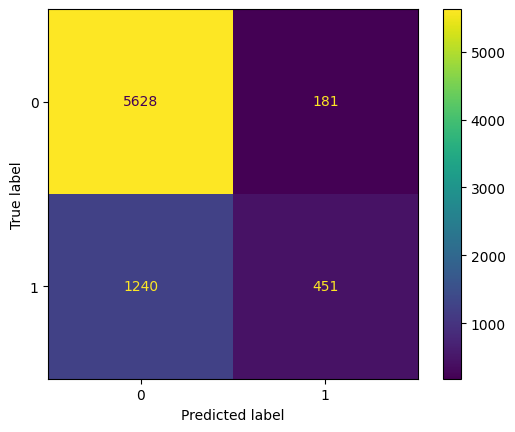

/home/gme/.cache/pypoetry/virtualenvs/src-yN7TRKYd-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


support vector machine 


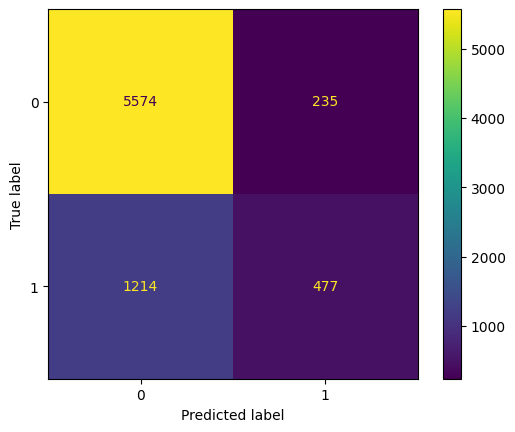

k nearest neighbors


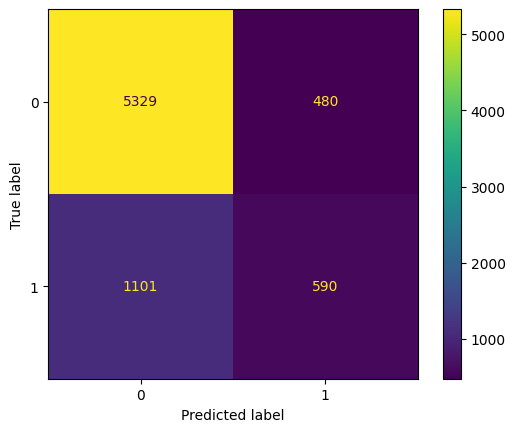

decision tree


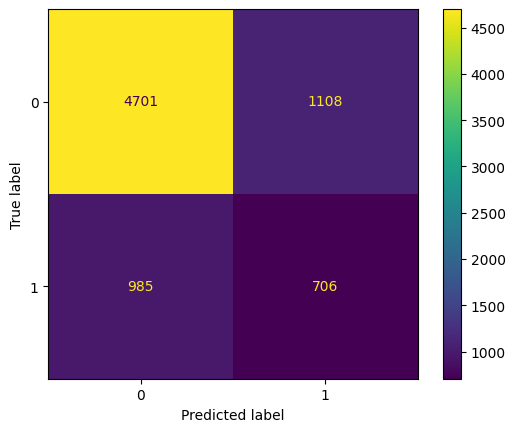

random forest


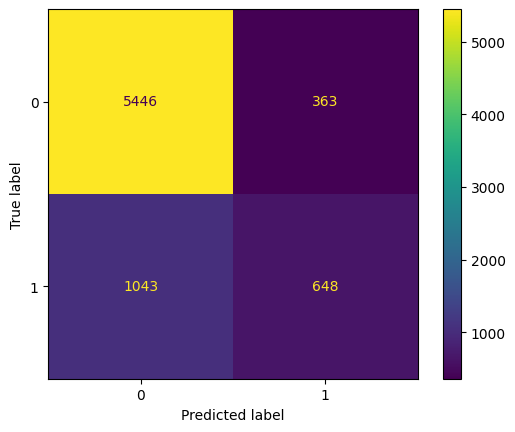

/home/gme/.cache/pypoetry/virtualenvs/src-yN7TRKYd-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mlp


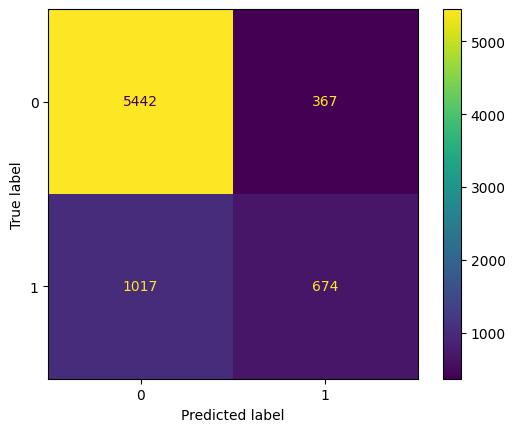

gaussian naive bayes


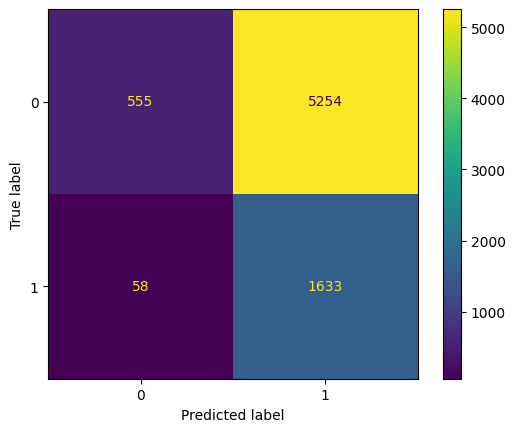

In [22]:
final_results = train_model(X_train.drop('label', axis=1),y_train,X_val,y_val) ## Dados desbalanceados para a classe 0

logistic regression


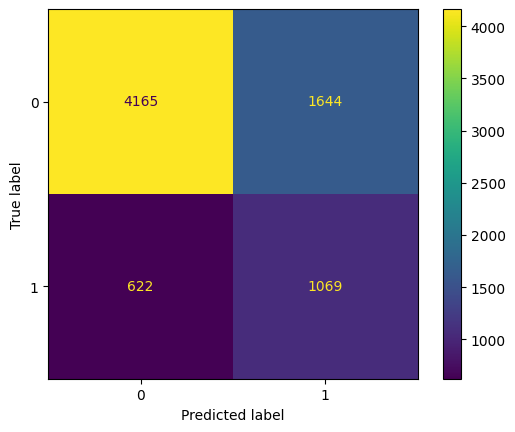

support vector machine 


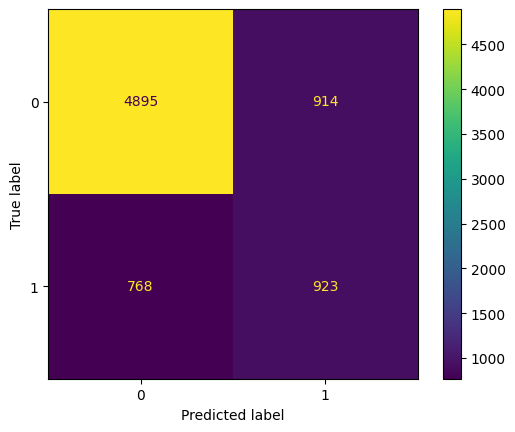

k nearest neighbors


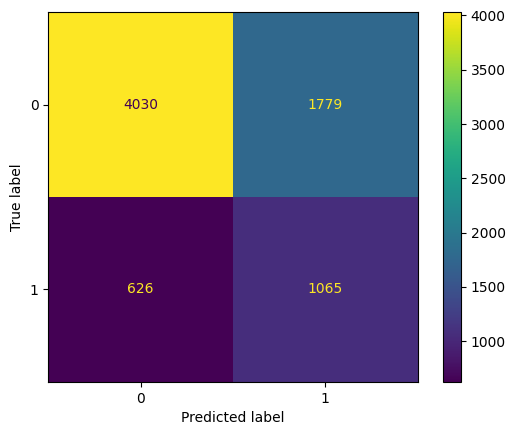

decision tree


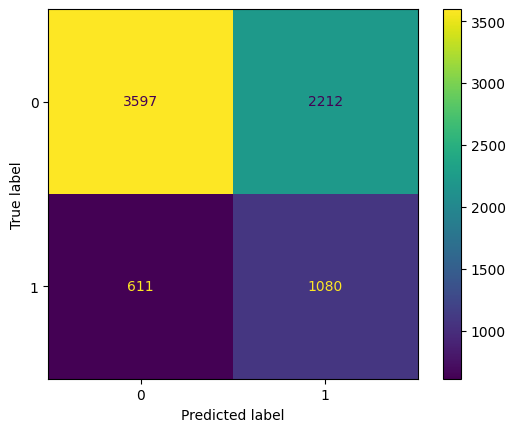

random forest


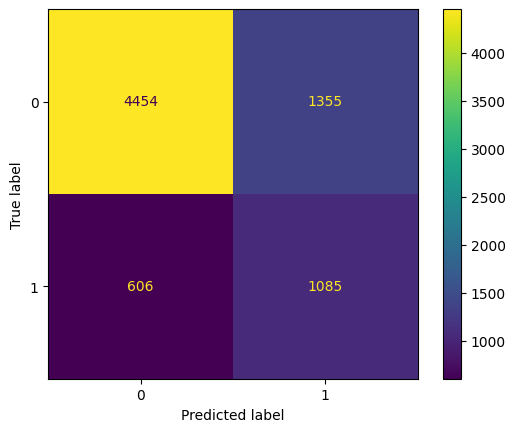

/home/gme/.cache/pypoetry/virtualenvs/src-yN7TRKYd-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mlp


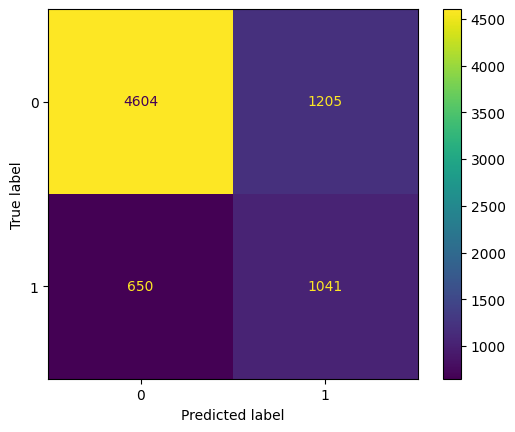

gaussian naive bayes


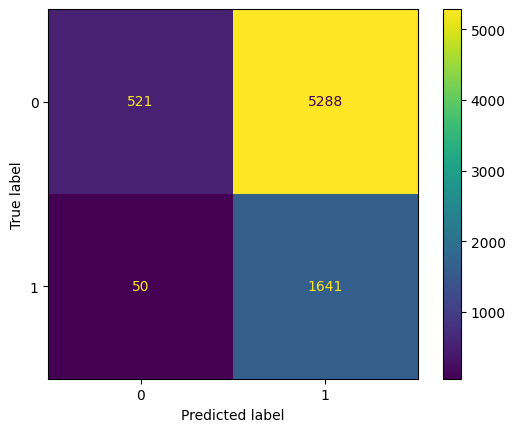

In [23]:
final_results2 = train_model(X_train2,y_train2,X_val,y_val) ## Dados balanceados

In [24]:
pd.DataFrame(final_results).groupby('name').agg([np.mean, np.std])

fit_time           score_time            \
                              mean       std       mean       std   
name                                                                
decision tree             0.753646  0.161667   0.015008  0.002262   
gaussian naive bayes      0.094728  0.024510   0.042902  0.014614   
k nearest neighbors       0.022783  0.008987   0.589989  0.144134   
logistic regression       1.542225  0.247387   0.033817  0.006235   
mlp                      36.613503  6.600541   0.026364  0.007646   
random forest             6.709146  0.674681   0.123803  0.017148   
support vector machine   31.375432  7.029732   1.519756  0.239928   

                        test_accuracy             test_f1            \
                                 mean       std      mean       std   
name                                                                  
decision tree                0.730267  0.009924  0.401899  0.031595   
gaussian naive bayes         0.281400  0.008598  0.372114  0.004567   
k nearest neighbors          0.791333  0.005666  0.407536  0.017629   
logistic regression          0.811133  0.007698  0.354989  0.027078   
mlp                          0.817733  0.007524  0.472866  0.031706   
random forest                0.815667  0.007776  0.470627  0.024051   
support vector machine       0.813067  0.006653  0.389068  0.026254   

                        test_recall           test_precision            
                               mean       std           mean       std  
name                                                                    
decision tree              0.413461  0.045810       0.392007  0.022382  
gaussian naive bayes       0.968174  0.013643       0.230322  0.002913  
k nearest neighbors        0.326469  0.017218       0.542748  0.021461  
logistic regression        0.236435  0.019692       0.714580  0.058654  
mlp                        0.372833  0.035548       0.649966  0.031215  
random forest              0.372847  0.023596       0.639460  0.034356  
support vector machine     0.270993  0.022345       0.692616  0.042188

In [25]:
pd.DataFrame(final_results2).groupby('name').agg([np.mean, np.std])

fit_time           score_time            \
                              mean       std       mean       std   
name                                                                
decision tree             0.354259  0.075035   0.032239  0.017405   
gaussian naive bayes      0.049639  0.030225   0.033550  0.017034   
k nearest neighbors       0.026974  0.020736   0.207633  0.058752   
logistic regression       0.784132  0.225478   0.031312  0.010191   
mlp                      23.393417  6.634203   0.023912  0.012780   
random forest             4.513990  0.660642   0.234770  0.077566   
support vector machine   10.448869  2.018495   0.596045  0.111808   

                        test_accuracy             test_f1            \
                                 mean       std      mean       std   
name                                                                  
decision tree                0.620943  0.021940  0.620802  0.028166   
gaussian naive bayes         0.523946  0.012877  0.670410  0.006386   
k nearest neighbors          0.660200  0.016248  0.645499  0.018355   
logistic regression          0.677784  0.014596  0.660402  0.018568   
mlp                          0.702033  0.012057  0.675365  0.021642   
random forest                0.704307  0.022148  0.684633  0.023728   
support vector machine       0.694760  0.011696  0.639274  0.017658   

                        test_recall           test_precision            
                               mean       std           mean       std  
name                                                                    
decision tree              0.621699  0.038873       0.620326  0.018577  
gaussian naive bayes       0.968170  0.009296       0.512771  0.007193  
k nearest neighbors        0.618982  0.022421       0.674629  0.017143  
logistic regression        0.627166  0.027088       0.697995  0.016499  
mlp                        0.621713  0.042762       0.741865  0.019669  
random forest              0.642016  0.024372       0.733521  0.025671  
support vector machine     0.541385  0.021978       0.780958  0.013464

/home/gme/.cache/pypoetry/virtualenvs/src-yN7TRKYd-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gme/.cache/pypoetry/virtualenvs/src-yN7TRKYd-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gme/.cache/pypoetry/virtualenvs/src-yN7TRKYd-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gme/.cache/pypoetry/virtualenvs/src-yN7TRKYd-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and